In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from commonen import h5dataset, traininer, onnxexporter

class JassTrumpDNN(nn.Module):
    def __init__(self, num_inputs=10, hidden_sizes=[64, 32]):
        super(JassTrumpDNN, self).__init__()
        layers = []
        in_dim = num_inputs * 37
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h

        self.hidden = nn.Sequential(*layers)
        self.policy_head = nn.Linear(in_dim, 7)

    def forward(self, state_idx):
        one_hot = F.one_hot(state_idx, num_classes=37).float()
        one_hot = one_hot.view(one_hot.size(0), -1) # Flatten the input
        x = self.hidden(one_hot)
        logits = self.policy_head(x)
        policy = F.log_softmax(logits, dim=1)
        return policy

In [2]:
DATASET_PATH = '../log_parser/dataset/flat_trump.hdf5'
MODLE_PATH = './models/jass_trump_dnn.pth'
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# Initialize model, optimizer, and loss function
model = JassTrumpDNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()

# set up trainer
traininer = traininer.Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=F.nll_loss,
    accuracy_fn=accuracy_fn,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [3]:
# train the model
traininer.train(NUM_EPOCHS)

Validation Epoch 1: 100%|██████████| 1650/1650 [00:04<00:00, 343.38it/s]


Epoch 1/10 - Train Loss: 0.5918, Train Accuracy: 0.7729, Val Loss: 0.5485, Val Accuracy: 0.7867
Model saved at epoch 1 with validation loss 0.5485


Validation Epoch 2: 100%|██████████| 1650/1650 [00:04<00:00, 347.79it/s]


Epoch 2/10 - Train Loss: 0.5324, Train Accuracy: 0.7933, Val Loss: 0.5310, Val Accuracy: 0.7937
Model saved at epoch 2 with validation loss 0.5310


Validation Epoch 3: 100%|██████████| 1650/1650 [00:04<00:00, 365.23it/s]


Epoch 3/10 - Train Loss: 0.5243, Train Accuracy: 0.7965, Val Loss: 0.5261, Val Accuracy: 0.7955
Model saved at epoch 3 with validation loss 0.5261


Validation Epoch 4: 100%|██████████| 1650/1650 [00:04<00:00, 357.02it/s]


Epoch 4/10 - Train Loss: 0.5206, Train Accuracy: 0.7974, Val Loss: 0.5253, Val Accuracy: 0.7959
Model saved at epoch 4 with validation loss 0.5253


Validation Epoch 5: 100%|██████████| 1650/1650 [00:04<00:00, 344.05it/s]


Epoch 5/10 - Train Loss: 0.5177, Train Accuracy: 0.7986, Val Loss: 0.5226, Val Accuracy: 0.7976
Model saved at epoch 5 with validation loss 0.5226


Validation Epoch 6: 100%|██████████| 1650/1650 [00:04<00:00, 348.00it/s]


Epoch 6/10 - Train Loss: 0.5155, Train Accuracy: 0.7994, Val Loss: 0.5238, Val Accuracy: 0.7966


Validation Epoch 7: 100%|██████████| 1650/1650 [00:04<00:00, 358.04it/s]


Epoch 7/10 - Train Loss: 0.5138, Train Accuracy: 0.7999, Val Loss: 0.5232, Val Accuracy: 0.7967


Validation Epoch 8: 100%|██████████| 1650/1650 [00:04<00:00, 360.48it/s]


Epoch 8/10 - Train Loss: 0.5121, Train Accuracy: 0.8005, Val Loss: 0.5203, Val Accuracy: 0.7978
Model saved at epoch 8 with validation loss 0.5203


Validation Epoch 9: 100%|██████████| 1650/1650 [00:04<00:00, 357.62it/s]


Epoch 9/10 - Train Loss: 0.5109, Train Accuracy: 0.8012, Val Loss: 0.5216, Val Accuracy: 0.7974


Validation Epoch 10: 100%|██████████| 1650/1650 [00:04<00:00, 339.06it/s]

Epoch 10/10 - Train Loss: 0.5099, Train Accuracy: 0.8015, Val Loss: 0.5207, Val Accuracy: 0.7981


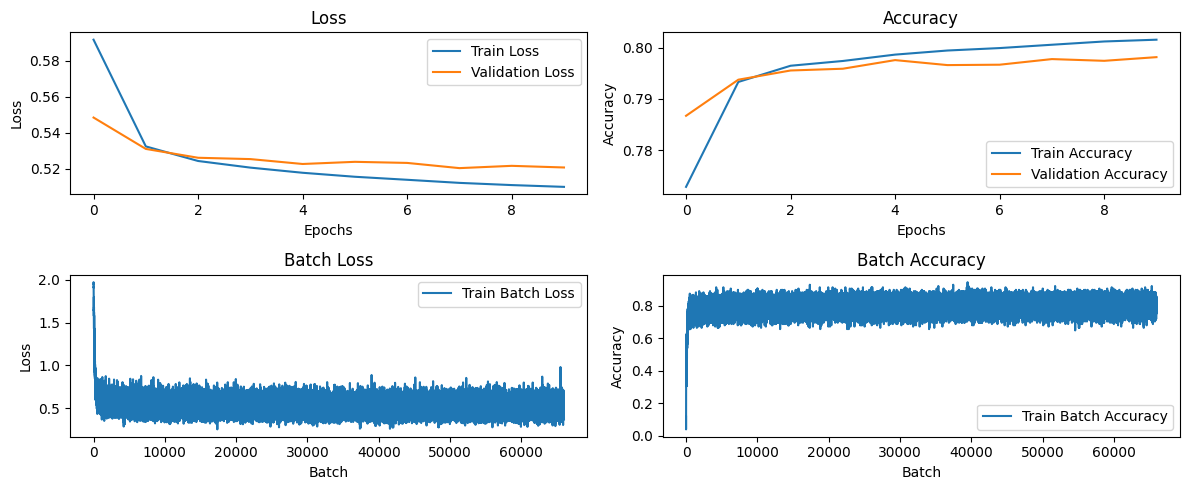

In [4]:
# create graphs
traininer.monitor.plot()

In [ ]:
# export the model to ONNX
ONNX_PATH = './onnx/jass_trump_dnn.onnx'
model = JassTrumpDNN() # Reinitialize the model for export on CPU
onnxexporter.onnx_exporter(
    model=model,
    in_dim=10,
    model_path=MODLE_PATH,
    output_path=ONNX_PATH
)

Successfully loaded trained model state dictionary from ./models/jass_trump_dnn.pth
Exporting model to ONNX format...
Successfully converted and saved ONNX model to ./onnx/jass_trump_dnn.onnx
